In [1]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import csv
import json
import pandas as pd
import math
import statistics

In [2]:
stats = {}

## Measured job load

In [3]:
csvfile = open('../cirrus-cpu-simple-rigid/data/raw-job-data/raw_job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
measured_job_l = []
maxtime = 0
for row in csvreader:
    if int(row['End Time']) > maxtime:
        maxtime = int(row['End Time'])
    if row['Nodes'] is None:
        print(row)
    measured_job_l.append(row)

measured_job_df = pd.DataFrame(measured_job_l)

print(measured_job_df)

measured_job_df['Start Time'] = measured_job_df['Start Time'].astype(int)
measured_job_df['Wait Time'] = measured_job_df['Wait Time'].astype(int)
measured_job_df['Nodes'] = measured_job_df['Nodes'].astype(int)
measured_job_df['Makespan'] = measured_job_df['Makespan'].astype(int)
measured_job_df['Turnaround Time'] = measured_job_df['Turnaround Time'].astype(int)
measured_job_df['Coreh'] = measured_job_df['Makespan'] * measured_job_df['Nodes'] / 3600.0
measured_job_df['Efficiency'] = measured_job_df['Makespan'] / measured_job_df['Turnaround Time']

print(measured_job_df)

print(measured_job_df['Coreh'].sum())

print(maxtime)

          ID   Type Submit Time Start Time End Time Wait Time Makespan  \
0          0  Rigid           0       2984     4407      2984     1423   
1          1  Rigid         715       3839     4287      3124      448   
2          2  Rigid         715       3839     4311      3124      472   
3          3  Rigid         715       4288     4708      3573      420   
4          4  Rigid        1698       4408     5886      2710     1478   
...      ...    ...         ...        ...      ...       ...      ...   
11630  11630  Rigid       23977      24094    24923       117      829   
11631  11631  Rigid       23980      23982    24011         2       29   
11632  11632  Rigid       23983      24792    25818       809     1026   
11633  11633  Rigid       23983      24804    25757       821      953   
11634  11634  Rigid       23983      24804    24894       821       90   

      Turnaround Time     Status Nodes  
0                4407  completed   756  
1                3572  comple

In [4]:
measured_load_a = np.zeros(maxtime+1, dtype=int)
totuse = 0
for job in measured_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = int(job['Start Time'])
    iend = int(job['End Time'])
    nodes = int(job['Nodes'])
    totuse = totuse + int(job['Makespan'])
    temp_a[istart:iend] = nodes
    measured_load_a = measured_load_a + temp_a

print(totuse)

4075948


<Figure size 640x480 with 0 Axes>

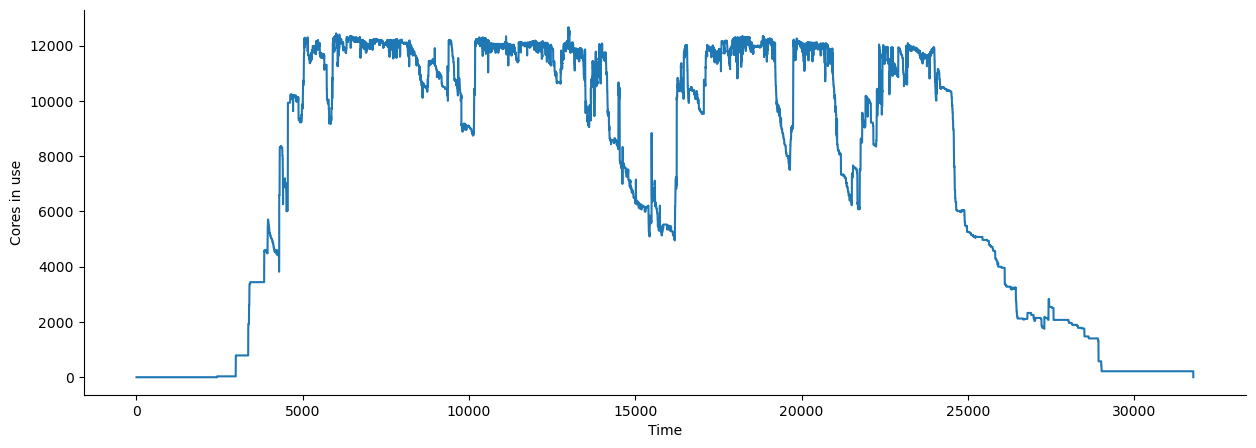

In [5]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.plot(measured_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("measured_load.png")

In [6]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Measured'
stats[type] = {}

stats[type]['nJobStart'] = sum((measured_job_df['Start Time'] >= timeLower) & (measured_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats[type]['nJobStart']}")

stats[type]['minLoad'] = min(measured_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(measured_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(measured_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(measured_load_a[timeLower:timeUpper+1])

usageVal = sum(measured_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal / 3600.0
stats[type]['usageExcluded'] = sum(measured_load_a[0:timeLower]) + sum(measured_load_a[timeUpper:]) / 3600.0
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * stats['Measured']['usageFraction']}")

measured_slice_df = measured_job_df.loc[(measured_job_df['Start Time'] >= timeLower) & (measured_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = measured_slice_df['Wait Time'].min()
stats[type]['medianWait'] = measured_slice_df['Wait Time'].median()
stats[type]['maxWait'] = measured_slice_df['Wait Time'].max()
stats[type]['meanWait'] = measured_slice_df['Wait Time'].mean()

print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTurnaroundTime'] = measured_slice_df['Turnaround Time'].min()
stats[type]['medianTurnaroundTime'] = measured_slice_df['Turnaround Time'].median()
stats[type]['maxTurnaroundTime'] = measured_slice_df['Turnaround Time'].max()
stats[type]['meanTurnaroundTime'] = measured_slice_df['Turnaround Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTurnaroundTime']}")
print(f" median = {stats[type]['medianTurnaroundTime']}")
print(f"    max = {stats[type]['maxTurnaroundTime']}")
print(f"   mean = {stats[type]['meanTurnaroundTime']}")



Job data:
    nJobs = 10749
Load statistics:
    min = 4949
 median = 11698
    max = 12664
   mean = 10677
 %usage = 80.60183465848094
Wait time statistics:
    min = 0
 median = 0.0
    max = 4255
   mean = 103.41752721183366
Total job time statistics:
    min = 1
 median = 36.0
    max = 12102
   mean = 437.3735231184296


## Simulated job load (rigid Cirrus + rigid ARCHER2)

In [7]:
csvfile = open('../cirrus-cpu-rigid-archer2-rigid/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
rigid_job_l = []
for row in csvreader:
    rigid_job_l.append(row)




In [8]:
jsonfile = open('../cirrus-cpu-rigid-archer2-rigid/data/input/2024_Q1_CPU-jobs.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
for job in jobs_d['jobs']:
    rigid_job_l[i]['Nodes'] = int(job['num_nodes'])
    rigid_job_l[i]['JobID'] = job['arguments']['jobid']
    totuse = totuse + float(rigid_job_l[i]['Makespan']) * rigid_job_l[i]['Nodes']
    if float(rigid_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(rigid_job_l[i]['End Time']))
    i += 1

rigid_job_df = pd.DataFrame(rigid_job_l)
rigid_job_df['Start Time'] = rigid_job_df['Start Time'].astype(int)
rigid_job_df['Wait Time'] = rigid_job_df['Wait Time'].astype(float)
rigid_job_df['Nodes'] = rigid_job_df['Nodes'].astype(int)
rigid_job_df['Makespan'] = rigid_job_df['Makespan'].astype(int)
rigid_job_df['Turnaround Time'] = rigid_job_df['Turnaround Time'].astype(int)
rigid_job_df['Coreh'] = rigid_job_df['Makespan'] * rigid_job_df['Nodes'] / 3600.0
rigid_job_df['Efficiency'] = rigid_job_df['Makespan'] / rigid_job_df['Turnaround Time']

print(rigid_job_df)

print(rigid_job_df['Coreh'].sum())

          ID   Type Submit Time  Start Time End Time  Wait Time  Makespan  \
0          0  rigid           0           0     1423        0.0      1423   
1          1  rigid           0           0    22868        0.0     22868   
2          2  rigid         207         207    19883        0.0     19676   
3          3  rigid         276         276    23140        0.0     22864   
4          4  rigid         542         542    23464        0.0     22922   
...      ...    ...         ...         ...      ...        ...       ...   
12049  12049  rigid       27398       31301    31990     3903.0       689   
12050  12050  rigid       27398       31402    32925     4004.0      1523   
12051  12051  rigid       29604       31446    33300     1842.0      1854   
12052  12052  rigid       29927       31479    33234     1552.0      1755   
12053  12053  rigid       29938       31508    33304     1570.0      1796   

       Turnaround Time     Status  Nodes        JobID    Coreh  Efficiency 

In [9]:
rigid_load_a = np.zeros(maxtime+1, dtype=int)

In [10]:
for job in rigid_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    rigid_load_a = rigid_load_a + temp_a

print(rigid_load_a)

[1332 1332 1332 ...   32   32    0]


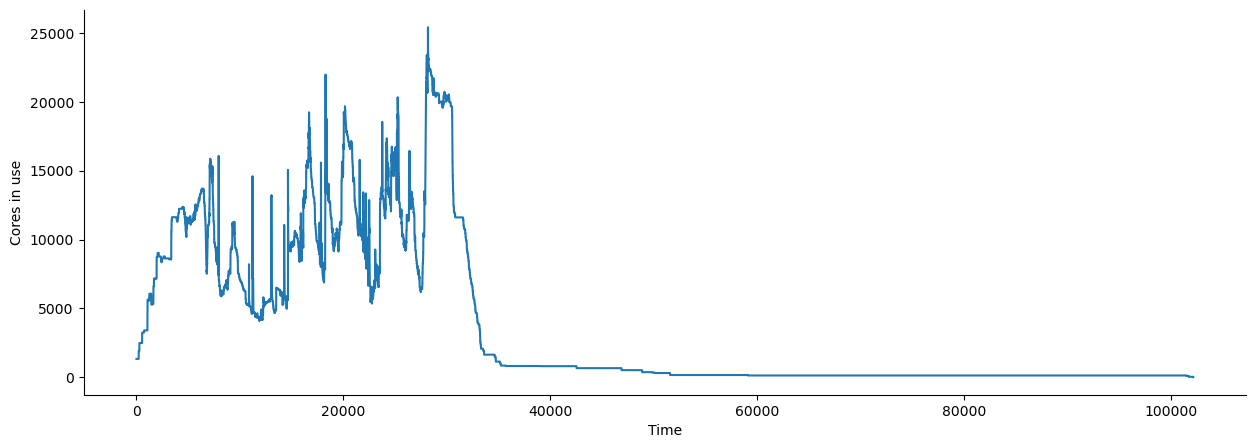

In [11]:
plt.figure(figsize=(15, 5))
plt.plot(rigid_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("simulated_load_rigid.png")

In [12]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Rigid'
stats[type] = {}


stats[type]['nJobStart'] = sum((rigid_job_df['Start Time'] >= timeLower) & (rigid_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats['Measured']['nJobStart']}")

stats[type]['minLoad'] = min(rigid_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(rigid_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(rigid_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(rigid_load_a[timeLower:timeUpper+1])

usageVal = sum(rigid_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal / 3600.0
stats[type]['usageExcluded'] = sum(rigid_load_a[0:timeLower]) + sum(rigid_load_a[timeUpper:]) / 3600.0
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * stats[type]['usageFraction']}")

rigid_slice_df = rigid_job_df.loc[(rigid_job_df['Start Time'] >= timeLower) & (rigid_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = rigid_slice_df['Wait Time'].min()
stats[type]['medianWait'] = rigid_slice_df['Wait Time'].median()
stats[type]['maxWait'] = rigid_slice_df['Wait Time'].max()
stats[type]['meanWait'] = rigid_slice_df['Wait Time'].mean()



print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTurnaroundTime'] = rigid_slice_df['Turnaround Time'].min()
stats[type]['medianTurnaroundTime'] = rigid_slice_df['Turnaround Time'].median()
stats[type]['maxTurnaroundTime'] = rigid_slice_df['Turnaround Time'].max()
stats[type]['meanTurnaroundTime'] = rigid_slice_df['Turnaround Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTurnaroundTime']}")
print(f" median = {stats[type]['medianTurnaroundTime']}")
print(f"    max = {stats[type]['maxTurnaroundTime']}")
print(f"   mean = {stats[type]['meanTurnaroundTime']}")



Job data:
    nJobs = 10749
Load statistics:
    min = 4103
 median = 9552
    max = 21981
   mean = 9653
 %usage = 72.87363962694579
Wait time statistics:
    min = 735.0
 median = 4093.0
    max = 5418.0
   mean = 3925.300834793363
Total job time statistics:
    min = 1167
 median = 4219.0
    max = 31142
   mean = 4285.789652684737


## Moldable jobs

In [52]:
csvfile = open('../cirrus-cpu-simple-moldable/data/output/job_statistics.csv', 'r')

csvreader = csv.DictReader(csvfile)
moldable_job_l = []
for row in csvreader:
    moldable_job_l.append(row)


print(moldable_job_l[0])
print(moldable_job_l[-1])


{'ID': '0', 'Type': 'moldable', 'Submit Time': '0', 'Start Time': '0', 'End Time': '711.5', 'Wait Time': '0', 'Makespan': '711.5', 'Turnaround Time': '711.5', 'Status': 'completed'}
{'ID': '11634', 'Type': 'moldable', 'Submit Time': '23983', 'Start Time': '24242.5', 'End Time': '24287.5', 'Wait Time': '259.5', 'Makespan': '45', 'Turnaround Time': '304.5', 'Status': 'completed'}


In [53]:
jsonfile = open('../cirrus-cpu-simple-moldable/data/input/2024_Q1_CPU-jobs_moldable.json', 'r')
jobs_d = json.load(jsonfile)
i = 0
maxtime = 0
totuse = 0
jobid_l = []
for job in jobs_d['jobs']:
    jobid_l.append(job['arguments']['jobid'])
    moldable_job_l[i]['JobID'] = job['arguments']['jobid']
    moldable_job_l[i]['BaseNodes'] = int(job['arguments']['base_nodes'])
    moldable_job_l[i]['MinNodes'] = int(job['num_nodes_min'])
    moldable_job_l[i]['MaxNodes'] = int(job['num_nodes_max'])
    i += 1


In [54]:
nodedata_df = pd.read_csv('../cirrus-cpu-simple-moldable/data/output/node_utilization.csv')
nodedata_df['Count'] = 1
nodedata_df.tail()

,Time,Node,State,Running jobs,Expected jobs,Count
1538754,28988.0,CCPU_11115,free,none,none,1
1538755,28988.0,CCPU_11116,free,none,none,1
1538756,28988.0,CCPU_11117,free,none,none,1
1538757,28988.0,CCPU_11118,free,none,none,1
1538758,28988.0,CCPU_11119,free,none,none,1


In [55]:
# nodecount_grouped = nodedata_df.groupby(by='Running jobs')['Count'].sum()
nodecount_grouped = nodedata_df.loc[nodedata_df['State'] == 'allocated'].groupby(by='Running jobs', sort=False)['Running jobs'].count()

In [56]:

for i, job in enumerate(moldable_job_l):
    cores = nodecount_grouped.iloc[i]
    moldable_job_l[i]['Nodes'] = cores
    totuse = totuse + float(moldable_job_l[i]['Makespan']) * moldable_job_l[i]['Nodes']
    if float(moldable_job_l[i]['End Time']) > maxtime:
        maxtime = math.ceil(float(moldable_job_l[i]['End Time']))

moldable_job_df = pd.DataFrame(moldable_job_l)
moldable_job_df['Start Time'] = moldable_job_df['Start Time'].astype(float)
moldable_job_df['Wait Time'] = moldable_job_df['Wait Time'].astype(float)
moldable_job_df['Nodes'] = moldable_job_df['Nodes'].astype(int)
moldable_job_df['Makespan'] = moldable_job_df['Makespan'].astype(float)
moldable_job_df['Coreh'] = moldable_job_df['Makespan'] * moldable_job_df['Nodes'] / 3600.0
moldable_job_df['Turnaround Time'] = moldable_job_df['Turnaround Time'].astype(float)
moldable_job_df['Efficiency'] = moldable_job_df['Makespan'] / moldable_job_df['Turnaround Time']
print(moldable_job_df)

print(moldable_job_df['Coreh'].sum())

          ID      Type Submit Time  Start Time End Time  Wait Time  Makespan  \
0          0  moldable           0         0.0    711.5        0.0     711.5   
1          1  moldable         715       715.0      939        0.0     224.0   
2          2  moldable         715       715.0      951        0.0     236.0   
3          3  moldable         715       715.0      925        0.0     210.0   
4          4  moldable        1698      1698.0     2437        0.0     739.0   
...      ...       ...         ...         ...      ...        ...       ...   
11630  11630  moldable       23977     24238.5    25482      261.5    1243.5   
11631  11631  moldable       23980     24240.0  24254.5      260.0      14.5   
11632  11632  moldable       23983     24242.5  24755.5      259.5     513.0   
11633  11633  moldable       23983     24242.5    24719      259.5     476.5   
11634  11634  moldable       23983     24242.5  24287.5      259.5      45.0   

       Turnaround Time     Status      

In [57]:
nrigid = len(moldable_job_df.loc[moldable_job_df['Nodes'] == moldable_job_df['BaseNodes']])
nmoldable = len(moldable_job_df.loc[moldable_job_df['Nodes'] != moldable_job_df['BaseNodes']])
nlarger = len(moldable_job_df.loc[moldable_job_df['Nodes'] > moldable_job_df['BaseNodes']])
nsmaller = len(moldable_job_df.loc[moldable_job_df['Nodes'] < moldable_job_df['BaseNodes']])
ntot = len(moldable_job_df)

print(f'Number of jobs at original size = {nrigid}/{ntot} ({100*nrigid/ntot:.2f}%)')
print(f'Number of jobs molded = {nmoldable}/{ntot} ({100*nmoldable/ntot:.2f}%)')
print(f'Number of jobs larger = {nlarger}/{ntot} ({100*nlarger/ntot:.2f}%)')
print(f'Number of jobs smaller = {nsmaller}/{ntot} ({100*nsmaller/ntot:.2f}%)')

Number of jobs at original size = 510/11635 (4.38%)
Number of jobs molded = 11125/11635 (95.62%)
Number of jobs larger = 10158/11635 (87.31%)
Number of jobs smaller = 967/11635 (8.31%)


In [58]:
moldable_load_a = np.zeros(maxtime+1, dtype=int)
for job in moldable_job_l:
    temp_a = np.zeros(maxtime+1, dtype=int)
    istart = math.floor(float(job['Start Time']))
    iend = math.ceil(float(job['End Time']))
    nodes = int(job['Nodes'])
    temp_a[istart:iend] = nodes
    moldable_load_a = moldable_load_a + temp_a

# With the moldable jobs, start and end times can be fractional
# This means that when they are floor'd and ceil'd you can end
# up with times where the load exceeds the number of cores available.
# Rather than doing something intelligent, we clip the array so it is
# in the correct range
moldable_load_a = np.clip(moldable_load_a, a_min=0, a_max=nCoreTot)

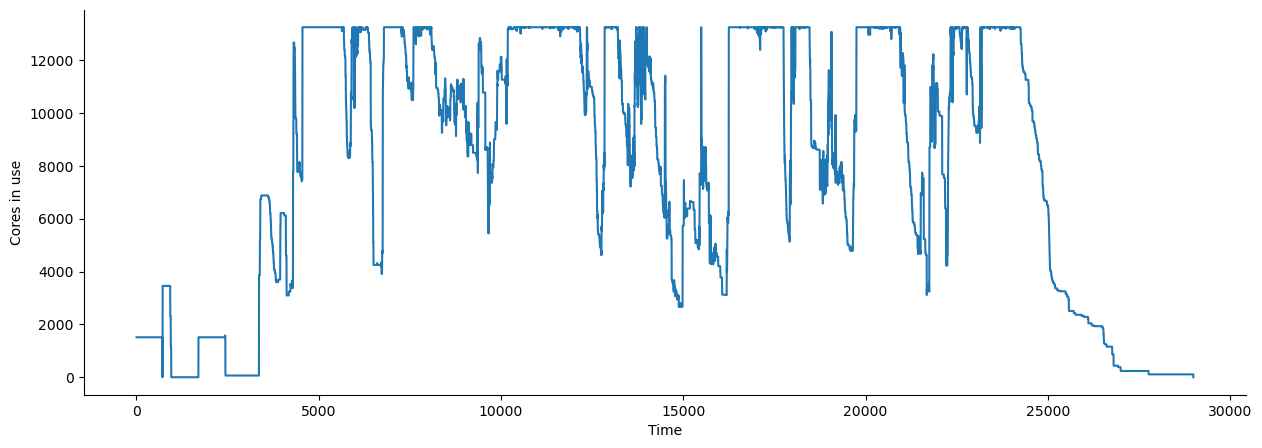

In [59]:
plt.figure(figsize=(15, 5))
plt.plot(moldable_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
sns.despine()
# plt.savefig("simulated_load_moldable.png")

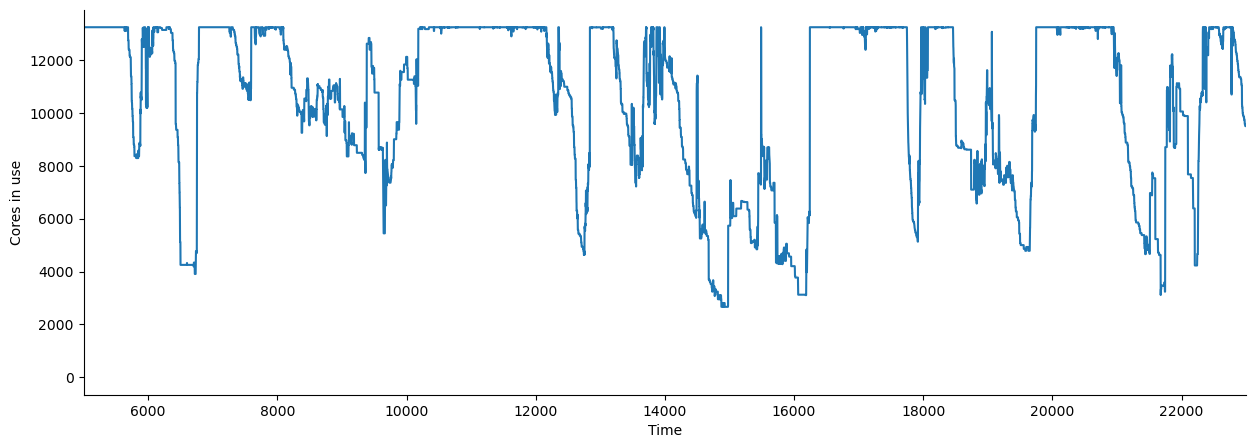

In [60]:
plt.figure(figsize=(15, 5))
plt.plot(moldable_load_a)
plt.xlabel("Time")
plt.ylabel("Cores in use")
plt.xlim([5000,23000])
sns.despine()

In [61]:
nCoreTot = 13248
timeLower = 5000
timeUpper= 23000
maxUsage = (timeUpper - timeLower) * nCoreTot

# Descriptive statistics
type = 'Moldable'
stats[type] = {}


stats[type]['nJobStart'] = sum((moldable_job_df['Start Time'] >= timeLower) & (moldable_job_df['Start Time'] <= timeUpper))

print(f"Job data:")
print(f"    nJobs = {stats[type]['nJobStart']}")

stats[type]['minLoad'] = min(moldable_load_a[timeLower:timeUpper+1])
stats[type]['maxLoad'] = max(moldable_load_a[timeLower:timeUpper+1])
stats[type]['medianLoad'] = statistics.median(moldable_load_a[timeLower:timeUpper+1])
stats[type]['meanLoad'] = statistics.mean(moldable_load_a[timeLower:timeUpper+1])

usageVal = sum(moldable_load_a[timeLower:timeUpper+1])
stats[type]['usageIncluded'] = usageVal / 3600.0
stats[type]['usageExcluded'] = sum(moldable_load_a[0:timeLower]) + sum(moldable_load_a[timeUpper:]) / 3600.0
stats[type]['usageFraction'] = usageVal/maxUsage

print(f"Load statistics:")
print(f"    min = {stats[type]['minLoad']}")
print(f" median = {stats[type]['medianLoad']}")
print(f"    max = {stats[type]['maxLoad']}")
print(f"   mean = {stats[type]['meanLoad']}")
print(f" %usage = {100 * stats[type]['usageFraction']}")

moldable_slice_df = moldable_job_df.loc[(moldable_job_df['Start Time'] >= timeLower) & (moldable_job_df['Start Time'] <= timeUpper)]
stats[type]['minWait'] = moldable_slice_df['Wait Time'].min()
stats[type]['medianWait'] = moldable_slice_df['Wait Time'].median()
stats[type]['maxWait'] = moldable_slice_df['Wait Time'].max()
stats[type]['meanWait'] = moldable_slice_df['Wait Time'].mean()



print(f"Wait time statistics:")
print(f"    min = {stats[type]['minWait']}")
print(f" median = {stats[type]['medianWait']}")
print(f"    max = {stats[type]['maxWait']}")
print(f"   mean = {stats[type]['meanWait']}")

stats[type]['minTurnaroundTime'] = moldable_slice_df['Turnaround Time'].min()
stats[type]['medianTurnaroundTime'] = moldable_slice_df['Turnaround Time'].median()
stats[type]['maxTurnaroundTime'] = moldable_slice_df['Turnaround Time'].max()
stats[type]['meanTurnaroundTime'] = moldable_slice_df['Turnaround Time'].mean()

print(f"Total job time statistics:")
print(f"    min = {stats[type]['minTurnaroundTime']}")
print(f" median = {stats[type]['medianTurnaroundTime']}")
print(f"    max = {stats[type]['maxTurnaroundTime']}")
print(f"   mean = {stats[type]['meanTurnaroundTime']}")



Job data:
    nJobs = 10742
Load statistics:
    min = 2664
 median = 11892
    max = 13248
   mean = 10605
 %usage = 80.05524020397209
Wait time statistics:
    min = -8.36735e-11
 median = 68.0604
    max = 988.0
   mean = 127.71315737084326
Total job time statistics:
    min = 0.5
 median = 146.89499999999998
    max = 12615.5
   mean = 336.99448259932973


## Comparisons

In [62]:
print(f"|              Stat |       Measured |     Rigid Sim. |  Moldable Sim. |")
print(f"|-------------------|----------------|----------------|----------------|")
print(f"| General stats     |                |                |                |")
print(f"|    Usage fraction | {stats['Measured']['usageFraction']:14.4f} | {stats['Rigid']['usageFraction']:14.4f} | {stats['Moldable']['usageFraction']:14.4f} |")
print(f"|             Coreh | {stats['Measured']['usageIncluded']:14.0f} | {stats['Rigid']['usageIncluded']:14.0f} | {stats['Moldable']['usageIncluded']:14.0f} |")
print(f"|              Jobs | {stats['Measured']['nJobStart']:14d} | {stats['Rigid']['nJobStart']:14d} | {stats['Moldable']['nJobStart']:14d} |")
print(f"| Load stats        |                |                |                |")
print(f"|         Min. load | {stats['Measured']['minLoad']:14.2f} | {stats['Rigid']['minLoad']:14.2f} | {stats['Moldable']['minLoad']:14.2f} |")
print(f"|       Median load | {stats['Measured']['medianLoad']:14.2f} | {stats['Rigid']['medianLoad']:14.2f} | {stats['Moldable']['medianLoad']:14.2f} |")
print(f"|         Mean load | {stats['Measured']['meanLoad']:14.2f} | {stats['Rigid']['meanLoad']:14.2f} | {stats['Moldable']['meanLoad']:14.2f} |")
print(f"|         Max. load | {stats['Measured']['maxLoad']:14.2f} | {stats['Rigid']['maxLoad']:14.2f} | {stats['Moldable']['maxLoad']:14.2f} |")
print(f"| Wait stats        |                |                |                |")
print(f"|         Min. wait | {stats['Measured']['minWait']:14.2f} | {stats['Rigid']['minWait']:14.2f} | {stats['Moldable']['minWait']:14.2f} |")
print(f"|       Median wait | {stats['Measured']['medianWait']:14.2f} | {stats['Rigid']['medianWait']:14.2f} | {stats['Moldable']['medianWait']:14.2f} |")
print(f"|         Mean wait | {stats['Measured']['meanWait']:14.2f} | {stats['Rigid']['meanWait']:14.2f} | {stats['Moldable']['meanWait']:14.2f} |")
print(f"|         Max. wait | {stats['Measured']['maxWait']:14.2f} | {stats['Rigid']['maxWait']:14.2f} | {stats['Moldable']['maxWait']:14.2f} |")
print(f"| Turnaround stats  |                |                |                |")
print(f"|   Min. turnaround | {stats['Measured']['minTurnaroundTime']:14.2f} | {stats['Rigid']['minTurnaroundTime']:14.2f} | {stats['Moldable']['minTurnaroundTime']:14.2f} |")
print(f"| Median turnaround | {stats['Measured']['medianTurnaroundTime']:14.2f} | {stats['Rigid']['medianTurnaroundTime']:14.2f} | {stats['Moldable']['medianTurnaroundTime']:14.2f} |")
print(f"|   Mean turnaround | {stats['Measured']['meanTurnaroundTime']:14.2f} | {stats['Rigid']['meanTurnaroundTime']:14.2f} | {stats['Moldable']['meanTurnaroundTime']:14.2f} |")
print(f"|   Max. turnaround | {stats['Measured']['maxTurnaroundTime']:14.2f} | {stats['Rigid']['maxTurnaroundTime']:14.2f} | {stats['Moldable']['maxTurnaroundTime']:14.2f} |")

|              Stat |       Measured |     Rigid Sim. |  Moldable Sim. |
|-------------------|----------------|----------------|----------------|
| General stats     |                |                |                |
|    Usage fraction |         0.8060 |         0.7989 |         0.8006 |
|             Coreh |          53391 |          52921 |          53029 |
|              Jobs |          10749 |          10714 |          10742 |
| Load stats        |                |                |                |
|         Min. load |        4949.00 |        3974.00 |        2664.00 |
|       Median load |       11698.00 |       11252.00 |       11892.00 |
|         Mean load |       10677.00 |       10583.00 |       10605.00 |
|         Max. load |       12664.00 |       13249.00 |       13248.00 |
| Wait stats        |                |                |                |
|         Min. wait |           0.00 |          -0.00 |          -0.00 |
|       Median wait |           0.00 |          48.

In [63]:
nrigid = len(moldable_slice_df.loc[moldable_slice_df['Nodes'] == moldable_slice_df['BaseNodes']])
nmoldable = len(moldable_slice_df.loc[moldable_slice_df['Nodes'] != moldable_slice_df['BaseNodes']])
nlarger = len(moldable_slice_df.loc[moldable_slice_df['Nodes'] > moldable_slice_df['BaseNodes']])
nsmaller = len(moldable_slice_df.loc[moldable_slice_df['Nodes'] < moldable_slice_df['BaseNodes']])
ntot = len(moldable_slice_df)

print(f'Number of jobs at original size = {nrigid}/{ntot} ({100*nrigid/ntot:.2f}%)')
print(f'Number of jobs molded = {nmoldable}/{ntot} ({100*nmoldable/ntot:.2f}%)')
print(f'Number of jobs larger = {nlarger}/{ntot} ({100*nlarger/ntot:.2f}%)')
print(f'Number of jobs smaller = {nsmaller}/{ntot} ({100*nsmaller/ntot:.2f}%)')

Number of jobs at original size = 481/10742 (4.48%)
Number of jobs molded = 10261/10742 (95.52%)
Number of jobs larger = 9382/10742 (87.34%)
Number of jobs smaller = 879/10742 (8.18%)


In [64]:
# Sort dataframes by job ID so we can compare between the two simulations
rigid_sort_df = rigid_job_df.sort_values(by='JobID', ascending=True)
moldable_sort_df = moldable_job_df.sort_values(by='JobID', ascending=True)

In [65]:
moldable_sort_df['Turnaround Change'] = moldable_sort_df['Turnaround Time'] / rigid_sort_df['Turnaround Time']

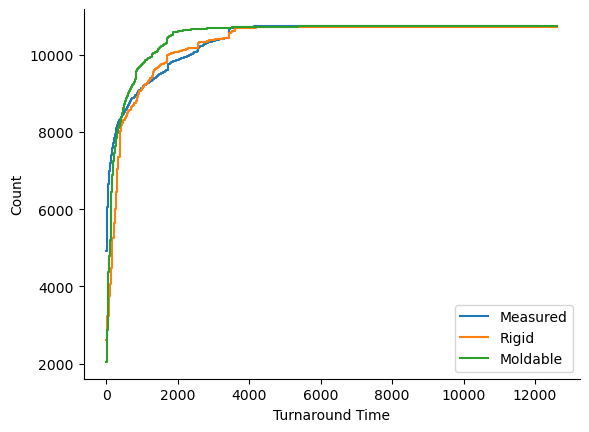

In [66]:
sns.histplot(data=measured_slice_df, x='Turnaround Time', element='step', fill=False, cumulative=True)
sns.histplot(data=rigid_slice_df, x='Turnaround Time', element='step', fill=False, cumulative=True)
sns.histplot(data=moldable_slice_df, x='Turnaround Time', element='step', fill=False, cumulative=True)
plt.legend(labels=['Measured', 'Rigid', 'Moldable'])
sns.despine()

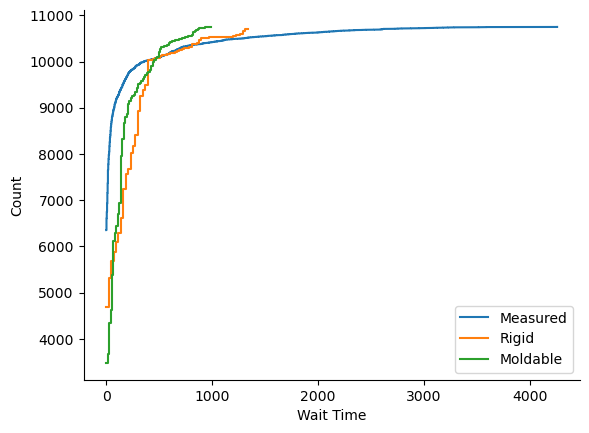

In [67]:
sns.histplot(data=measured_slice_df, x='Wait Time', element='step', fill=False, cumulative=True)
sns.histplot(data=rigid_slice_df, x='Wait Time', element='step', fill=False, cumulative=True)
sns.histplot(data=moldable_slice_df, x='Wait Time', element='step', fill=False, cumulative=True)
plt.legend(labels=['Measured', 'Rigid', 'Moldable'])
sns.despine()

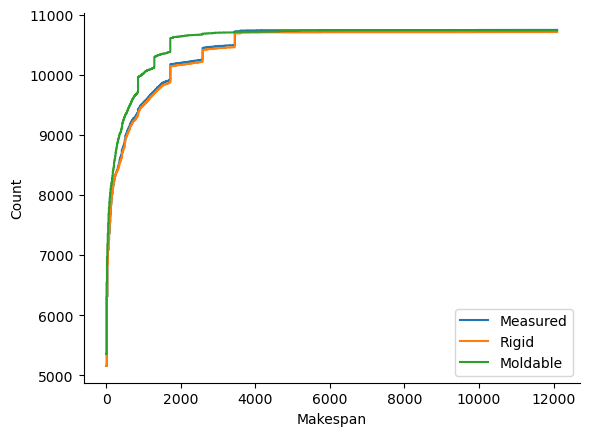

In [68]:
sns.histplot(data=measured_slice_df, x='Makespan', element='step', fill=False, cumulative=True)
sns.histplot(data=rigid_slice_df, x='Makespan', element='step', fill=False, cumulative=True)
sns.histplot(data=moldable_slice_df, x='Makespan', element='step', fill=False, cumulative=True)
plt.legend(labels=['Measured', 'Rigid', 'Moldable'])
sns.despine()